<a href="https://colab.research.google.com/github/DilshadFayiz/AI-project-Biotecnika/blob/main/ML_ANTICANCER_COMPOUNDS_1994.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**(1) Preprocessing and Feature Extraction**

In [ ]:
#Install rdkit
!pip install --upgrade rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 51.3 MB/s eta 0:00:00


In [ ]:
#Install numpy
!pip install numpy

I. Clean Data:

In [ ]:
import pandas as pd

# Try reading the CSV with a different encoding
try:
    df = pd.read_csv('/content/Anticancer_compounds@1994.csv', encoding='latin-1')
    print("Successfully read with latin-1 encoding")
except UnicodeDecodeError:
    try:
        df = pd.read_csv('/content/Anticancer_compounds@1994.csv', encoding='cp1252')
        print("Successfully read with cp1252 encoding")
    except UnicodeDecodeError:
        print("Could not decode the file with latin-1 or cp1252 encoding. Please check the file encoding.")
        df = None # Set df to None if decoding fails

if df is not None:
    print(df.head())

Successfully read with latin-1 encoding
         Compound_Name  MOL_WEIGHT  IC50 (µM)  \
0         CHEMBL170406     438.420      0.500   
1        CHEMBL3980848     478.890      1.000   
2       (-)-Kurarinone     438.520      0.600   
3   1,4-Naphthoquinone     158.156      0.340   
4  13-DEOXYDOXORUBICIN     529.542      0.891   

                                         Target Name  \
0  Inhibitor of nuclear factor kappa-B kinase sub...   
1  Inhibitor of nuclear factor kappa-B kinase sub...   
2      PTGS1 - prostaglandin-endoperoxide synthase 1   
3  MAP2K1 - mitogen-activated protein kinase kina...   
4                                               U2OS   

                                              SMILES  
0  N#Cc1c(-c2ccc(NC(=O)CCCC(=O)[O-])cc2)cc(-c2ccc...  
1  NC(=O)c1nn(-c2ccc(F)cc2F)c2c1CCc1ccc(NC(=O)c3c...  
2  CC(=CCC(CC1=C2C(=C(C=C1O)OC)C(=O)C[C@H](O2)C3=...  
3                         C1=CC=C2C(=O)C=CC(=O)C2=C1  
4  COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)... 

In [ ]:
import pandas as pd
from rdkit import Chem

# Load your CSV file
try:
    df = pd.read_csv('/content/Anticancer_compounds@1994.csv', encoding='latin-1')
    print("Successfully read with latin-1 encoding")
except UnicodeDecodeError:
    try:
        df = pd.read_csv('/content/Anticancer_compounds@1994.csv', encoding='cp1252')
        print("Successfully read with cp1252 encoding")
    except UnicodeDecodeError:
        print("Could not decode the file with latin-1 or cp1252 encoding. Please check the file encoding.")
        df = None # Set df to None if decoding fails

if df is not None:
    # Clean up column names by stripping whitespace
    df.columns = df.columns.str.strip()

    # Drop rows with missing IC50 values
    df = df.dropna(subset=["IC50 (µM)"])

    # Drop duplicate SMILES entries
    df = df.drop_duplicates(subset=["SMILES"])

    # Validate SMILES using RDKit
    def is_valid_smiles(smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            return mol is not None
        except:
            return False

    # Filter only valid SMILES
    df["is_valid"] = df["SMILES"].apply(is_valid_smiles)
    df_clean = df[df["is_valid"]].drop(columns=["is_valid"])

    # Save cleaned CSV
    df_clean.to_csv("Anticancer_compounds@1994_cleaned.csv", index=False)
    print("Cleaned data saved to 'Anticancer_compounds@1994_cleaned.csv'")

II. Generate Molecular Descriptors:


In [ ]:
# Generate molecular Descriptors

from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors # Ensure Descriptors is imported
import pandas as pd # Import pandas
from rdkit import Chem # Import Chem

# Load the cleaned data
try:
    df_clean = pd.read_csv("Anticancer_compounds@1994_cleaned.csv")
    print("Cleaned data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Anticancer_compounds@1994_cleaned.csv' not found. Please ensure the cleaning steps were successful.")
    df_clean = None


if df_clean is not None:
    # Generate RDKit descriptors
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

    def generate_descriptors(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return descriptor_calculator.CalcDescriptors(mol)
        else:
            return [None] * len(descriptor_names) # Return None for invalid molecules

    df_clean["Descriptors"] = df_clean["SMILES"].apply(generate_descriptors)

    # Expand the list of descriptors into separate columns
    descriptor_data = pd.DataFrame(df_clean["Descriptors"].tolist(), columns=descriptor_names, index=df_clean.index)

    # Concatenate the descriptors dataframe with the original cleaned dataframe
    df_final = pd.concat([df_clean.drop(columns=["Descriptors"]), descriptor_data], axis=1)

    # Save the dataframe with descriptors
    df_final.to_csv("Anticancer_compounds@1994_with_descriptors.csv", index=False)
    print("Data with molecular descriptors saved to 'Anticancer_compounds@1994_with_descriptors.csv'")
else:
    print("Cleaned dataframe 'df_clean' not found. Please ensure the cleaning steps were successful.")

Cleaned data loaded successfully.
Data with molecular descriptors saved to 'Anticancer_compounds@1994_with_descriptors.csv'


III. Create Fingerprints:

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd
# from rdkit.Chem.rdFingerprintGenerator import MorganGenerator # Remove this import
import numpy as np

# Load the cleaned data
df_clean = pd.read_csv("Anticancer_compounds@1994_cleaned.csv")

# Generate RDKit molecule objects from SMILES
molecules = df_clean['SMILES'].apply(Chem.MolFromSmiles)

# Generate Morgan fingerprints using AllChem.GetMorganFingerprintAsBitVect
fingerprints = []

for i, mol in enumerate(molecules):
    if mol is not None:
        # Generate Morgan fingerprint as a bit vector
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        # Convert the bit vector to a list of integers (0s and 1s)
        fp_list = [int(bit) for bit in fingerprint.ToBitString()]
        # print(f"Molecule at index {i}: Fingerprint length = {len(fp_list)}") # Keep this for debugging if needed
        if len(fp_list) != 1024:
            print(f"Warning: Fingerprint for molecule at index {i} has unexpected length: {len(fp_list)}")
        fingerprints.append(fp_list)
    else:
        # Append a list of zeros for invalid molecules if necessary
        fingerprints.append([0] * 1024) # Assuming 1024 bits as defined by nBits


# Create a DataFrame from the fingerprints directly, specifying dtype
fingerprint_df = pd.DataFrame(fingerprints, columns=[f'Morgan_{i}' for i in range(1024)], dtype=int)

# Concatenate the original DataFrame with the fingerprint DataFrame
df_clean_with_fingerprints = pd.concat([df_clean, fingerprint_df], axis=1)


# Display the first few rows of the DataFrame with fingerprints
print(df_clean_with_fingerprints.head())

# Optionally, save the DataFrame with fingerprints to a new CSV
df_clean_with_fingerprints.to_csv("Anticancer_compounds@1994_with_fingerprints.csv", index=False)
print("\nData with fingerprints generated by AllChem.GetMorganFingerprintAsBitVect saved to 'Anticancer_compounds@1994_with_fingerprints.csv'")

[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerator
[15:07:54] DEPRECATION WARNING: please use MorganGenerat

         Compound_Name  MOL_WEIGHT  IC50 (µM)  \
0         CHEMBL170406     438.420      0.500   
1        CHEMBL3980848     478.890      1.000   
2       (-)-Kurarinone     438.520      0.600   
3   1,4-Naphthoquinone     158.156      0.340   
4  13-DEOXYDOXORUBICIN     529.542      0.891   

                                         Target Name  \
0  Inhibitor of nuclear factor kappa-B kinase sub...   
1  Inhibitor of nuclear factor kappa-B kinase sub...   
2      PTGS1 - prostaglandin-endoperoxide synthase 1   
3  MAP2K1 - mitogen-activated protein kinase kina...   
4                                               U2OS   

                                              SMILES  Morgan_0  Morgan_1  \
0  N#Cc1c(-c2ccc(NC(=O)CCCC(=O)[O-])cc2)cc(-c2ccc...         0         0   
1  NC(=O)c1nn(-c2ccc(F)cc2F)c2c1CCc1ccc(NC(=O)c3c...         0         0   
2  CC(=CCC(CC1=C2C(=C(C=C1O)OC)C(=O)C[C@H](O2)C3=...         0         1   
3                         C1=CC=C2C(=O)C=CC(=O)C2=C1         0  

IV.  Normalize Data:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import ast # Import ast to safely evaluate the string representation of the list

# Load the dataframe with descriptors
try:
    df_with_descriptors = pd.read_csv("Anticancer_compounds@1994_with_descriptors.csv")
    print("Data with descriptors loaded successfully.")
except FileNotFoundError:
    print("Error: 'Anticancer_compounds@1994_with_descriptors.csv' not found. Please ensure the descriptor generation step ran successfully.")
    df_with_descriptors = None


if df_with_descriptors is not None:
    # Convert the string representation of the list in 'Morgan_Fingerprint' to an actual list of integers
    # This column might not exist in the descriptor file, so handle potential KeyError
    if 'Morgan_Fingerprint' in df_with_descriptors.columns:
        df_with_descriptors['Morgan_Fingerprint'] = df_with_descriptors['Morgan_Fingerprint'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else None)


    # Select only the numerical descriptor columns for scaling
    # Exclude non-numerical columns and the fingerprint column
    # You may need to adjust the columns based on your specific descriptor set
    numerical_cols = df_with_descriptors.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Exclude the 'IC50' column if it's your target variable and you don't want to scale it
    if 'IC50 (µM)' in numerical_cols:
        numerical_cols.remove('IC50 (µM)')

    # Exclude the 'BioAssay AID' column as it is an identifier (assuming this column might exist based on common datasets)
    if 'BioAssay AID' in numerical_cols:
        numerical_cols.remove('BioAssay AID')


    # Exclude the 'Morgan_Fingerprint' column as it's a list of integers, not a single numerical value
    if 'Morgan_Fingerprint' in numerical_cols:
        numerical_cols.remove('Morgan_Fingerprint')

    print(f"Numerical columns selected for scaling: {numerical_cols}")

    if numerical_cols:
        scaler = MinMaxScaler()

        # Apply scaling to the selected numerical columns
        df_with_descriptors[numerical_cols] = scaler.fit_transform(df_with_descriptors[numerical_cols])

        display(df_with_descriptors.head())

        # Optionally, save the normalized data
        df_with_descriptors.to_csv("Anticancer_compounds@1994_with_normalized.csv", index=False)
        print("\nNormalized data saved to 'Anticancer_compounds@1994_with_normalized.csv'")
    else:
        print("No numerical columns found for scaling after exclusions.")
        display(df_with_descriptors.head())
else:
    print("Could not proceed with normalization as 'df_with_descriptors' was not loaded.")

Data with descriptors loaded successfully.
Numerical columns selected for scaling: ['MOL_WEIGHT', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_V

,Compound_Name,MOL_WEIGHT,IC50 (µM),Target Name,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL170406,0.734911,0.500,Inhibitor of nuclear factor kappa-B kinase sub...,N#Cc1c(-c2ccc(NC(=O)CCCC(=O)[O-])cc2)cc(-c2ccc...,0.720769,0.720769,0.000000,0.662015,0.397732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL3980848,0.831368,1.000,Inhibitor of nuclear factor kappa-B kinase sub...,NC(=O)c1nn(-c2ccc(F)cc2F)c2c1CCc1ccc(NC(=O)c3c...,0.937625,0.937625,0.019184,0.711940,0.418925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,(-)-Kurarinone,0.735149,0.600,PTGS1 - prostaglandin-endoperoxide synthase 1,CC(=CCC(CC1=C2C(=C(C=C1O)OC)C(=O)C[C@H](O2)C3=...,0.815783,0.815783,0.005293,0.722452,0.478831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"1,4-Naphthoquinone",0.066922,0.340,MAP2K1 - mitogen-activated protein kinase kina...,C1=CC=C2C(=O)C=CC(=O)C2=C1,0.664479,0.664479,0.076949,0.817142,0.583470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13-DEOXYDOXORUBICIN,0.952093,0.891,U2OS,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,0.856425,0.856425,0.013777,0.609615,0.206159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Normalized data saved to 'Anticancer_compounds@1994_with_normalized.csv'


**(2) Machine Learning Model Development**



**Steps:**

I. Split the Data:

*   Divide the dataset into training, validation, and test sets:

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the normalized data
df_normalized = pd.read_csv("Anticancer_compounds@1994_with_normalized.csv")

# Define features (X) and target (y)
# X will be all columns except 'IC50' and non-numerical columns like SMILES and Morgan_Fingerprint
# y will be the 'IC50' column
columns_to_drop = ['IC50 (µM)', 'SMILES', 'Compound_Name', 'Target Name', 'MOL_WEIGHT'] # Updated list based on available columns
X = df_normalized.drop(columns=columns_to_drop)
y = df_normalized['IC50 (µM)']

# Convert all columns in X to numeric, coercing errors, and fill NaNs
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill NaN values (e.g., with the mean of each column)
X = X.fillna(X.mean())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Added random_state for reproducibility

print("Data split successfully:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split successfully:
X_train shape: (1595, 217)
X_test shape: (399, 217)
y_train shape: (1595,)
y_test shape: (399,)


II. Build a QSAR Model:

*   Train a Random Forest Model for regression:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42) # Added random_state for reproducibility
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

III. Evaluate the Model:
* Use metrics like R² and RMSE:

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np # Import numpy to use sqrt

predictions = model.predict(X_test)
print("R²:", r2_score(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions))) # Calculate RMSE manually

R²: 0.5427548029427673
RMSE: 0.2227381727535847


IV. Visualize Results:

*   Plot predicted vs. actual values using Matplotlib:

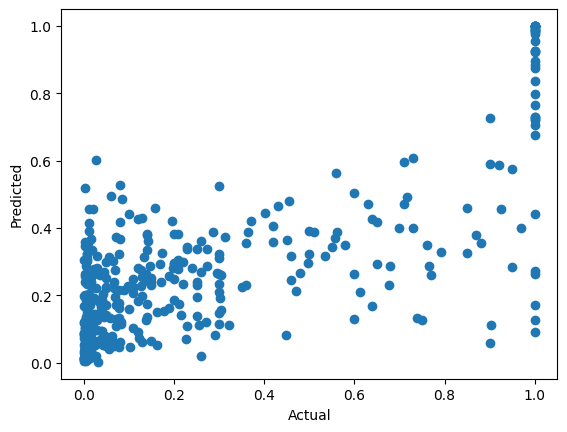

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


**(3) Molecular Docking**


Below are the Docking results which were performed against five cancer target proteins:

In [ ]:
import pandas as pd

docking_df = pd.read_csv('/content/Docking_results@303(EGFR).csv')
display(docking_df.head())
import pandas as pd

docking_df = pd.read_csv('/content/Docking_results@303(P53).csv')
display(docking_df.head())
import pandas as pd

docking_df = pd.read_csv('/content/Docking_results@303(bcl-2).csv')
display(docking_df.head())
import pandas as pd

docking_df = pd.read_csv('/content/Docking_results@akt1.csv')
display(docking_df.head())
import pandas as pd

docking_df = pd.read_csv('/content/binding_energies(IKKβ).csv')
display(docking_df.head())

,Compound_Name,EGFR_Binding_Energy
0,(-)-Kurarinone,-7.732
1,"1,4-Naphthoquinone",-5.949
2,13-DEOXYDOXORUBICIN,-9.485
3,370572-36-4,-7.921
4,5-Desmethylsinensetin,-7.608


,Compound_Name,P53_Binding_Energy
0,(-)-Kurarinone,-8.245
1,"1,4-Naphthoquinone",-6.048
2,13-DEOXYDOXORUBICIN,-10.079
3,370572-36-4,-8.614
4,5-Desmethylsinensetin,-8.187


,Compound_Name,BCL-2_Binding_Energy
0,(-)-Kurarinone,-6.849
1,"1,4-Naphthoquinone",-5.886
2,13-DEOXYDOXORUBICIN,-7.188
3,370572-36-4,-7.056
4,5-Desmethylsinensetin,-6.648


,AKT1_Binding_Energy
0,-14.486
1,-14.338
2,-14.326
3,-14.295
4,-14.248


,Compound_Name,Binding_Energy
0,BDBM50465331,-13.049
1,CHEMBL3945032,-11.662
2,BDBM50441566,-11.658
3,CHEMBL3926593,-11.277
4,CHEMBL3976791,-11.195


**(4) ADMET Prediction**

pkCSM website was used for predicting **ADMET** properties

In [ ]:
import pandas as pd

# Try reading the CSV with different encodings
try:
    admet_df = pd.read_csv('/content/Admet_data@1994_Anticancer_compounds.csv', encoding='latin-1')
    print("Successfully read ADMET data with latin-1 encoding")
except UnicodeDecodeError:
    try:
        admet_df = pd.read_csv('/content/Admet_data@1994_Anticancer_compounds.csv', encoding='cp1252')
        print("Successfully read ADMET data with cp1252 encoding")
    except UnicodeDecodeError:
        print("Could not decode the ADMET data file with latin-1 or cp1252 encoding. Please check the file encoding.")
        admet_df = None # Set admet_df to None if decoding fails

if admet_df is not None:
    display(admet_df.head())

Successfully read ADMET data with latin-1 encoding


,Compound_Name,IC50 (µM),Target Name,SMILES,MOL_WEIGHT,LOGP,#ROTATABLE_BONDS,#H_BOND_ACCEPTORS,#H_BOND_DONORS,SURFACE_AREA,...,AMES toxicity,Max. tolerated dose (human),hERG I inhibitor,hERG II inhibitor,Oral Rat Acute Toxicity (LD50),Oral Rat Chronic Toxicity (LOAEL),Hepatotoxicity,Skin Sensitisation,T.Pyriformis toxicity,Minnow toxicity
0,Periplogenin,0.810,Human HT1080 cells,C[C@]12CC[C@@H](C[C@]1(CC[C@@H]3[C@@H]2CC[C@]4...,390.520,2.71920,1,5.0,3.0,166.707,...,No,-0.428,No,No,2.282,1.716,No,No,0.330,1.945
1,ENILURACIL,0.014,Dihydropyrimidine dehydrogenase,C#Cc1c[nH]c(=O)[nH]c1=O,136.110,-0.95550,0,2.0,2.0,55.923,...,No,1.143,No,No,1.745,1.547,No,No,-0.686,2.864
2,FLUOROURACIL,0.300,MCF7,O=c1[nH]cc(F)c(=O)[nH]1,130.078,-0.79770,0,2.0,2.0,48.359,...,No,1.113,No,No,1.712,1.671,No,No,-0.481,3.249
3,Helenalin,0.210,Human SKLU1 cells,C[C@@H]1C[C@@H]2[C@H]([C@@H]([C@]3([C@H]1C=CC3...,262.305,1.24630,0,4.0,1.0,111.683,...,Yes,0.381,No,No,1.952,2.454,No,No,0.440,1.935
4,TIPIRACIL,0.020,Thymidine phosphorylase,N=C1CCCN1Cc1[nH]c(=O)[nH]c(=O)c1Cl,242.666,0.28967,2,3.0,3.0,95.761,...,No,0.802,No,No,2.169,1.324,Yes,No,-0.185,2.624
